In [1]:
%reload_ext autoreload
%autoreload 21
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *

## Create your own painting

For this lesson, we'll be using a copy of the bedrooms LSUN project of Jeremy Howards lesson 6. I donwload the pictures from google images and the Van Gogh dataset on http://academictorrents.com/details/c8b687c984d3d902310f27d56759ed69f5e1b4a7.

In [3]:
path = Path('../data/painter/')

In [4]:
path.ls()

[PosixPath('../data/painter/models'),
 PosixPath('../data/painter/vermeer'),
 PosixPath('../data/painter/leonardo'),
 PosixPath('../data/painter/vincent'),
 PosixPath('../data/painter/rembrandt'),
 PosixPath('../data/painter/Van.gogh.paintings')]

We then grab all the images in the folder with the data block API. We don't create a validation set here for reasons we'll explain later. It consists of random noise of size 100 by default (can be changed below) as inputs and the images of paintings as targets. That's why we do `tfm_y=True` in the transforms, then apply the normalization to the ys and not the xs.

In [5]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .no_split()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

We'll begin with a small side and use gradual resizing.

In [8]:
data = get_data(512, 64)

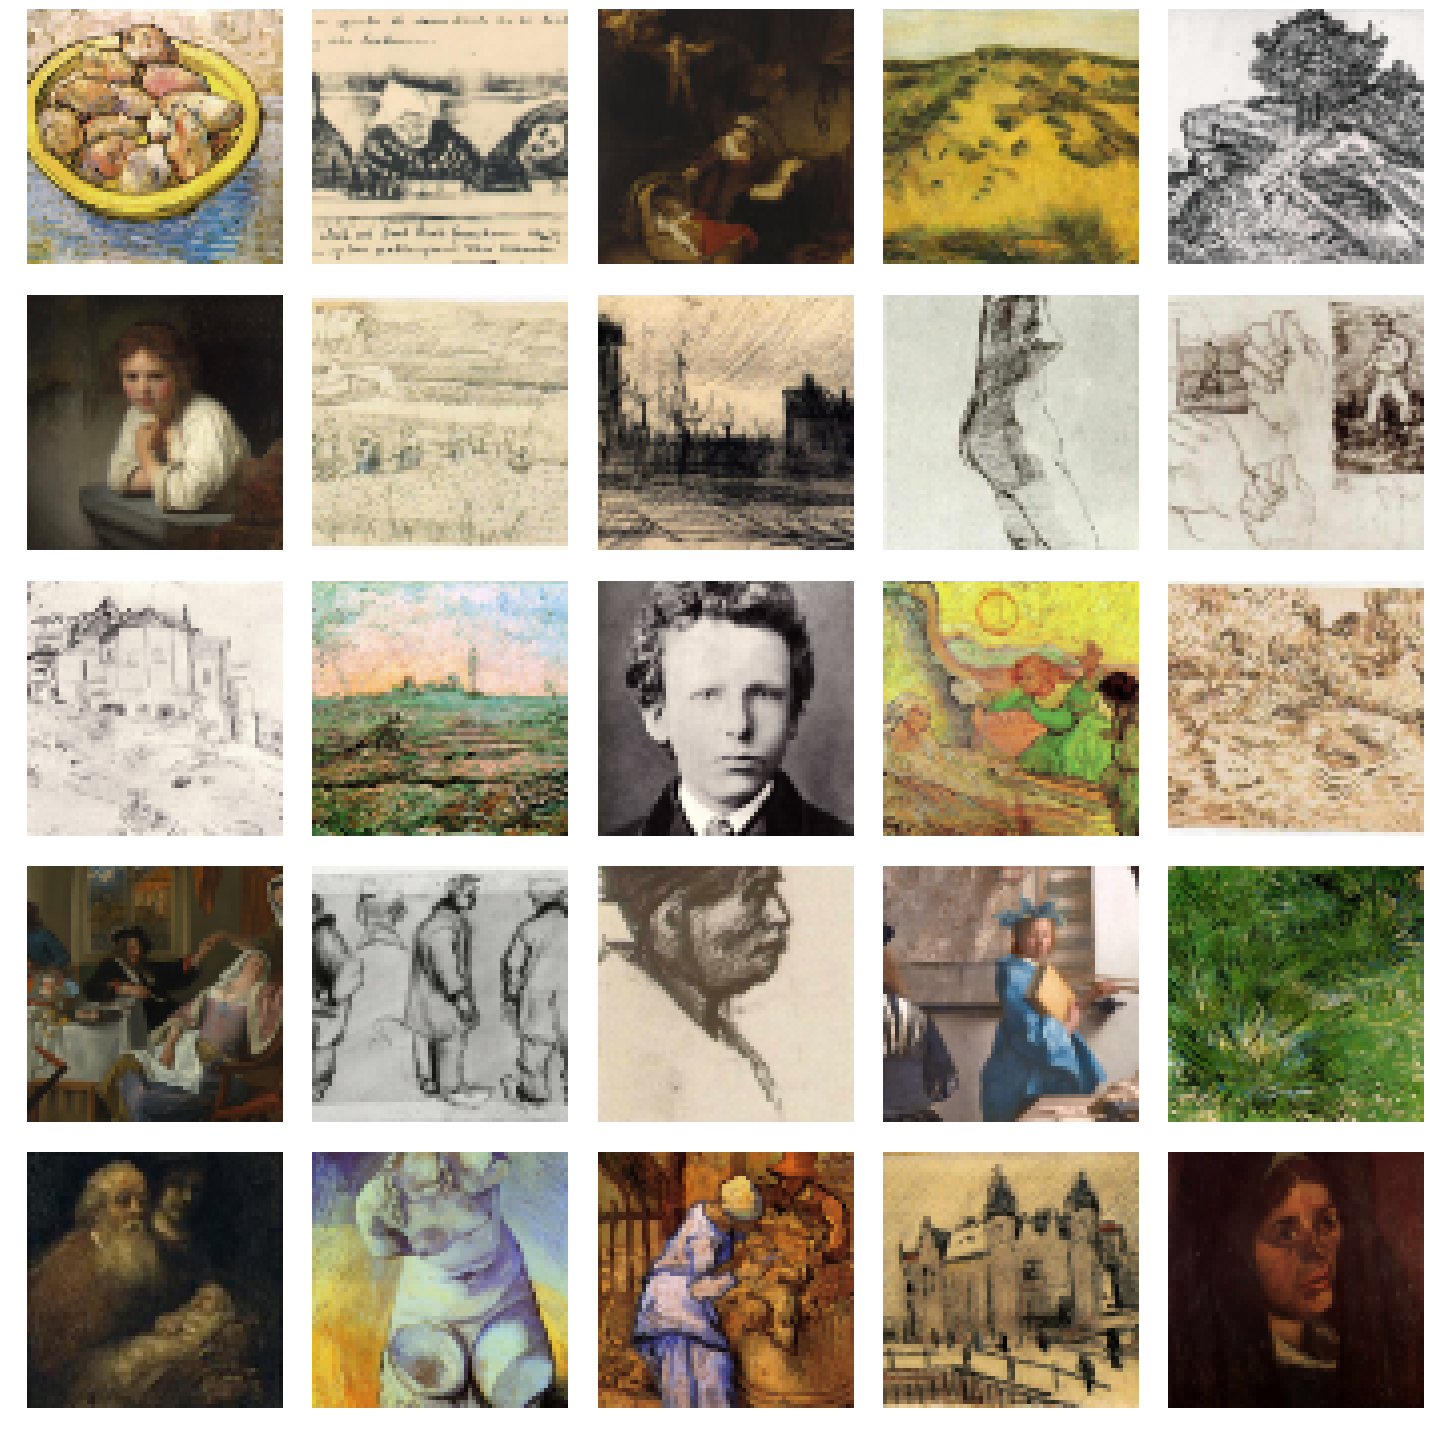

In [9]:
data.show_batch(rows=5)

## Models

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in our dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:
1. Freeze the generator and train the critic for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the critic with the gradients of this loss
  
  
2. Freeze the critic and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the critic on it
  - return a loss that rewards posisitivly the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the generator with the gradients of this loss
  
Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

We create a generator and a critic that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.

In [10]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [11]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,gen_loss,disc_loss
1,-1.343206,0.792287,-1.582694
2,-1.217553,0.792661,-1.584355
3,-1.168549,0.792844,-1.585131
4,-1.227406,0.792921,-1.585731
5,-1.195243,0.793072,-1.586061
6,-1.169480,0.793181,-1.586327
7,-1.212446,0.793232,-1.586577
8,-1.190460,0.793265,-1.586788
9,-1.170009,0.793309,-1.586983
10,-1.207471,0.793321,-1.587147


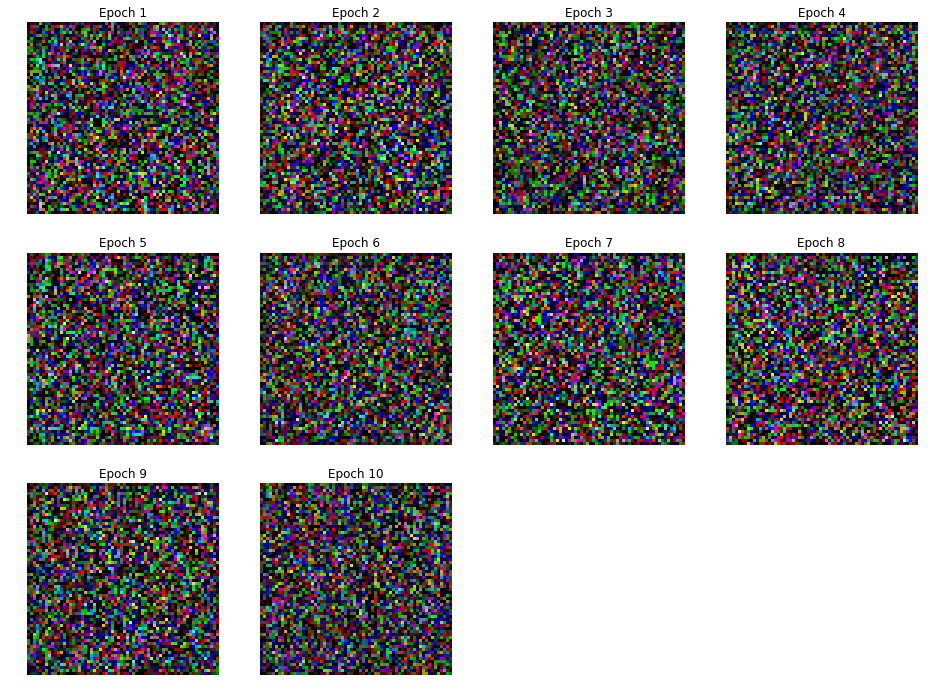

In [16]:
learn.fit(10,2e-5)

epoch,train_loss,gen_loss,disc_loss
1,-0.314348,0.462609,-0.406990
2,-0.150178,0.225887,-0.221729
3,-0.113199,0.242348,-0.192309
4,-0.150337,0.197320,-0.211782
5,-0.153061,0.184166,-0.218317
6,-0.152476,0.215490,-0.231491
7,-0.145947,0.209025,-0.213581
8,-0.136352,0.222070,-0.211268
9,-0.173254,0.187189,-0.243014
10,-0.179863,0.190445,-0.245065


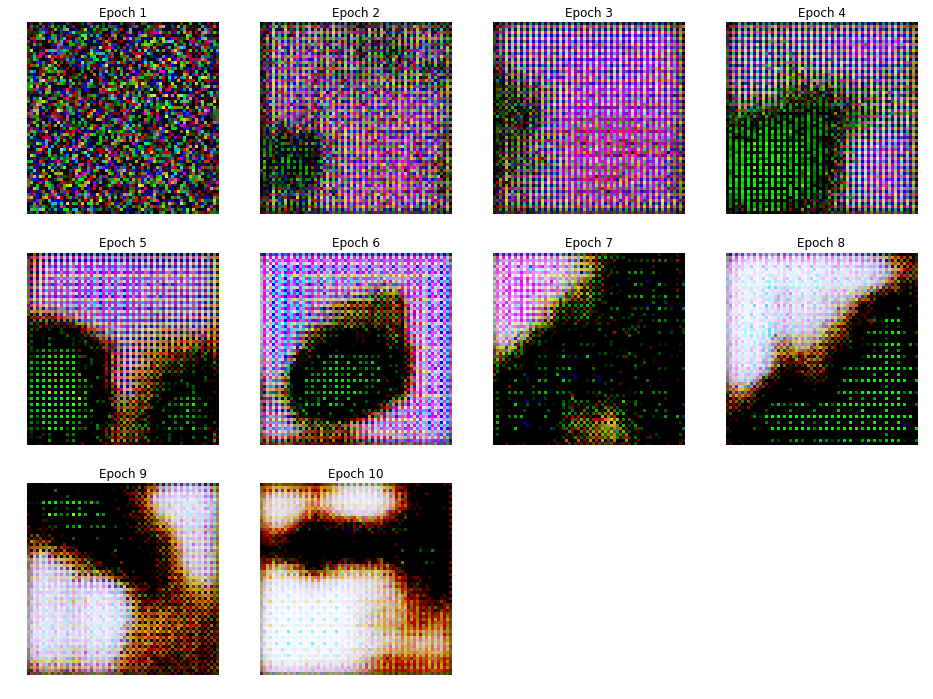

In [17]:
learn.fit(10,1e-3)

epoch,train_loss,gen_loss,disc_loss
1,-0.365543,0.604886,-0.474227
2,-0.315231,0.540450,-0.471425
3,-0.321042,0.426947,-0.475954
4,-0.318989,0.444659,-0.453610
5,-0.326450,0.421741,-0.470442
6,-0.322335,0.443015,-0.483734
7,-0.326725,0.441385,-0.470071
8,-0.317606,0.350986,-0.443646
9,-0.329305,0.282736,-0.442087
10,-0.328086,0.291470,-0.434401


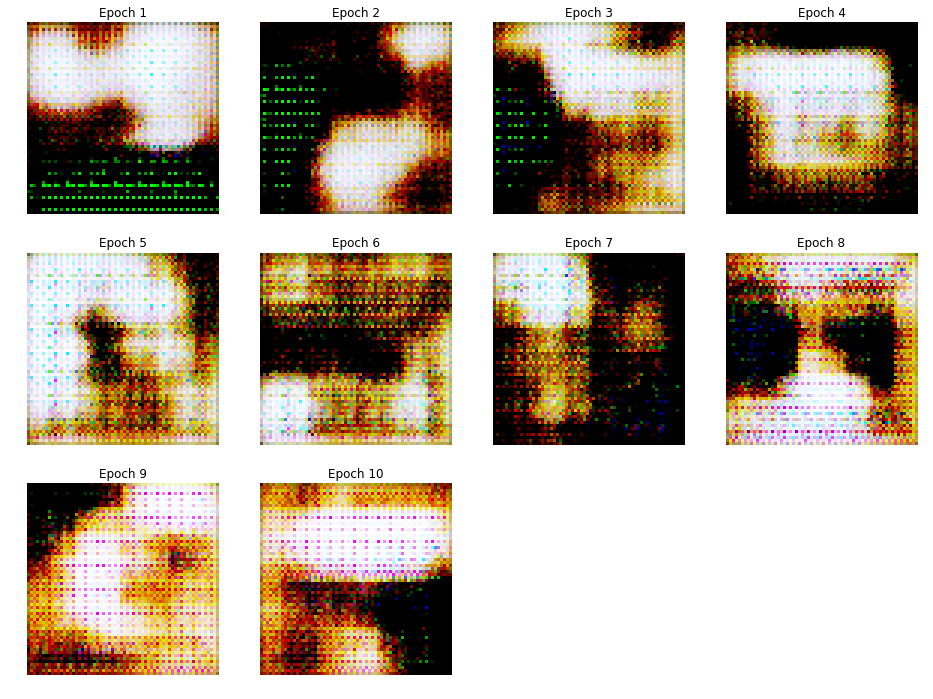

In [18]:
learn.fit(10,5e-4)

epoch,train_loss,gen_loss,disc_loss
1,-0.760208,0.539781,-0.904107
2,-0.817924,0.606241,-1.074609
3,-0.850646,0.630484,-1.161492
4,-0.945360,0.638857,-1.221638
5,-0.949016,0.651090,-1.258712
6,-0.950146,0.661450,-1.287773
7,-1.006794,0.665716,-1.313685
8,-1.002322,0.672275,-1.332002
9,-0.996348,0.678459,-1.347576
10,-1.041731,0.681313,-1.363927


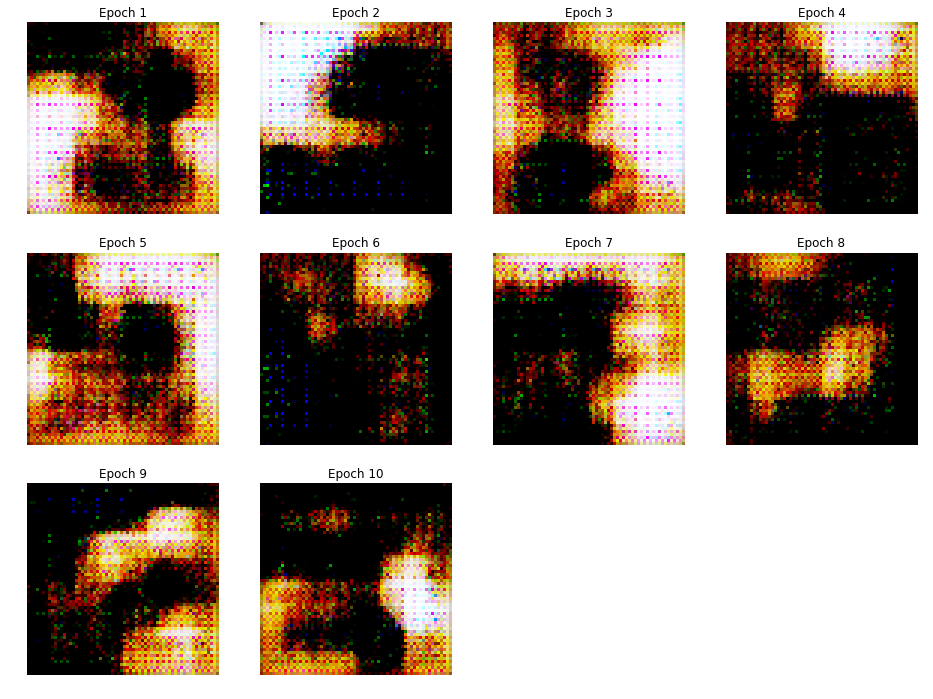

In [19]:
learn.fit(10,5e-5)

epoch,train_loss,gen_loss,disc_loss
1,-0.369353,0.484749,-0.467586
2,-0.292617,0.122870,-0.366330
3,-0.199102,0.293855,-0.309304
4,-0.206264,0.209572,-0.281000
5,-0.190597,0.178792,-0.262946
6,-0.224490,0.031640,-0.265597
7,-0.205037,0.058012,-0.248225
8,-0.198745,0.035207,-0.239564
9,-0.192358,0.010690,-0.228846
10,-0.195737,0.038839,-0.238500


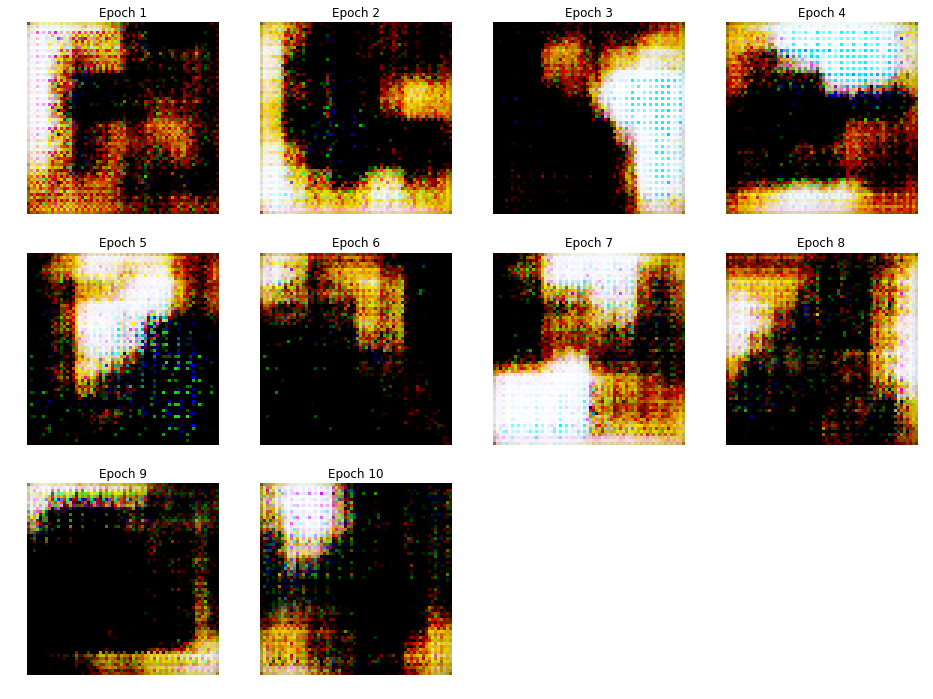

In [20]:
learn.fit(10,8e-4)

epoch,train_loss,gen_loss,disc_loss
1,-1.291024,0.761773,-1.521256
2,-1.168287,0.759589,-1.520116
3,-1.119019,0.759076,-1.517988
4,-1.173154,0.758867,-1.515969
5,-1.141967,0.758330,-1.515598
6,-1.079705,0.681214,-1.450767
7,-0.926006,0.674971,-1.239224
8,-0.922418,0.679268,-1.252878
9,-0.942282,0.687626,-1.293900
10,-1.011808,0.692410,-1.335673


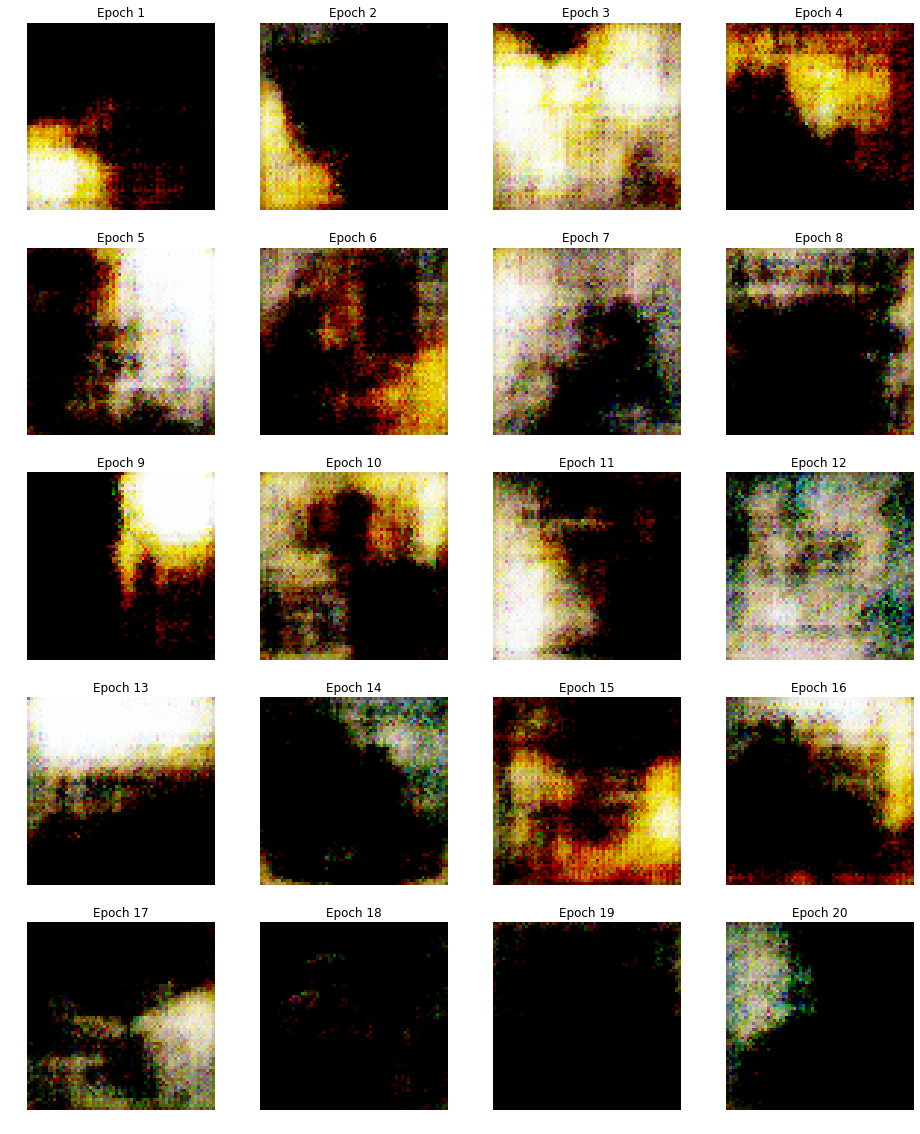

In [25]:
learn.fit(20,2e-4)

epoch,train_loss,gen_loss,disc_loss
1,-0.510193,-0.466107,-0.517502
2,-0.409012,-0.070887,-0.473551
3,-0.457175,0.012520,-0.556590
4,-0.483530,0.061908,-0.581653
5,-0.511523,0.197199,-0.655100
6,-0.545594,0.188107,-0.699508
7,-0.676250,0.236248,-0.838514
8,-0.753466,0.316457,-0.959308
9,-0.811236,0.379364,-1.057482
10,-0.906484,0.405754,-1.145094


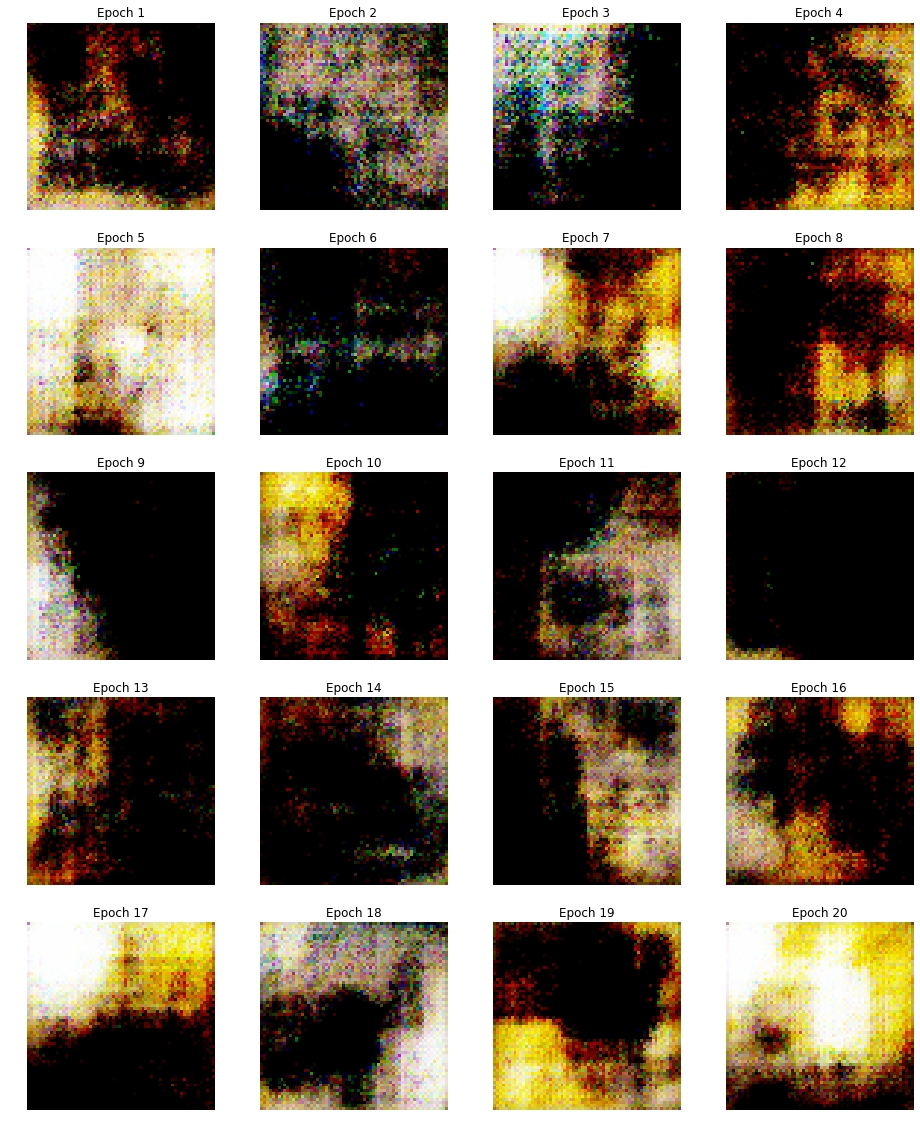

In [24]:
learn.fit(20,3e-4)

In [26]:
learn.save('first-60e')

In [9]:
learn.load('first-60e')

GANLearner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (2622 items)
[Image (3, 786, 1400), Image (3, 1436, 1100), Image (3, 2479, 1660), Image (3, 2220, 2220), Image (3, 1343, 1200)]...
Path: ../data/painter
x: GANItemList (2622 items)
[NoisyItem , NoisyItem , NoisyItem , NoisyItem , NoisyItem ]...
Path: ../data/painter;

Valid: LabelList
y: ImageItemList (0 items)
[]...
Path: ../data/painter
x: GANItemList (0 items)
[]...
Path: ../data/painter;

Test: None, model=GANModule(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): 

epoch,train_loss,gen_loss,disc_loss
1,-0.940844,0.570843,-1.109894
2,-0.892605,0.589977,-1.162227
3,-0.877964,0.605006,-1.192031
4,-0.942526,0.610869,-1.216631
5,-0.931823,0.619979,-1.235307
6,-0.923142,0.627333,-1.250886
7,-0.969424,0.630320,-1.265779
8,-0.960941,0.636208,-1.278014
9,-0.952120,0.641537,-1.288723
10,-0.992651,0.643683,-1.300762


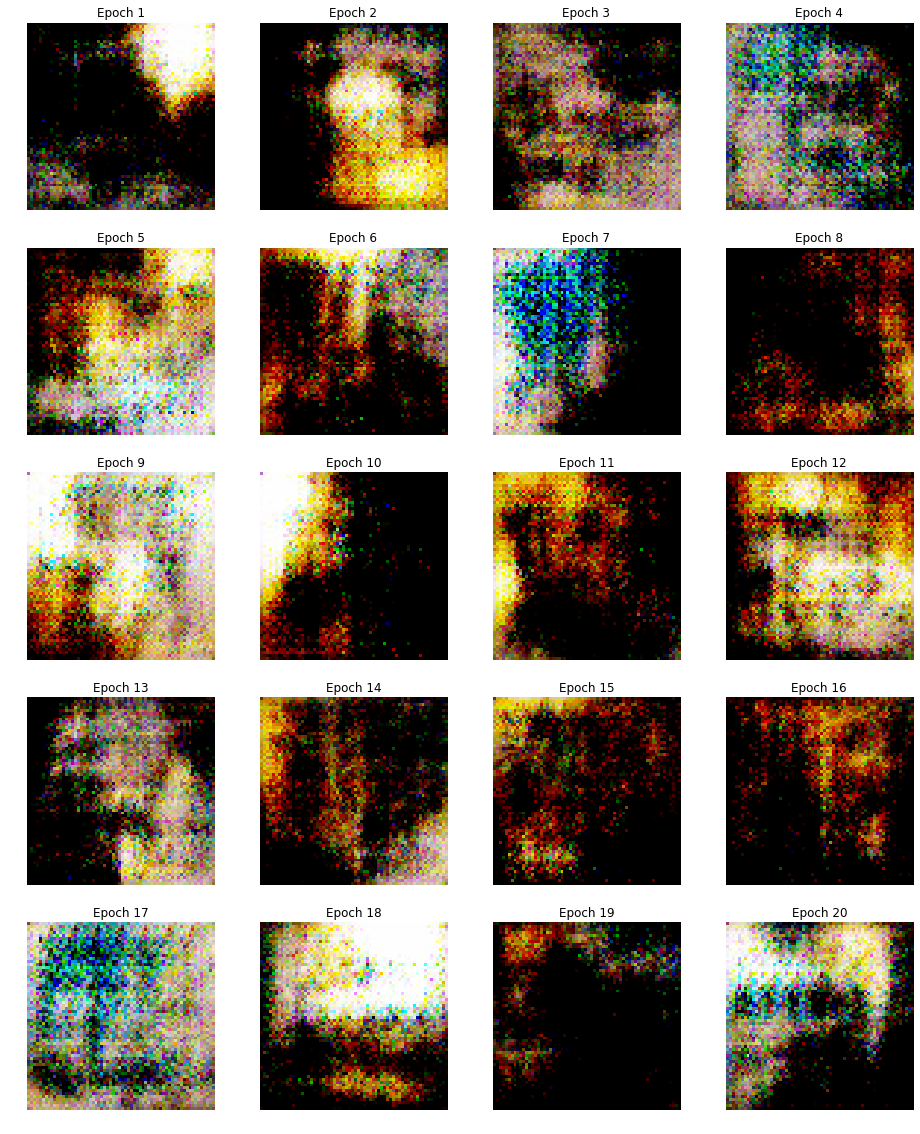

In [23]:
learn.fit(20,5e-5)

In [18]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=2, figsize=(32,32))

FileNotFoundError: Traceback (most recent call last):
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/fastai/data_block.py", line 521, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/fastai/data_block.py", line 94, in __getitem__
    if isinstance(idxs, numbers.Integral): return self.get(idxs)
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/fastai/vision/data.py", line 266, in get
    res = self.open(fn)
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/fastai/vision/data.py", line 262, in open
    return open_image(fn, convert_mode=self.convert_mode)
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/fastai/vision/image.py", line 376, in open_image
    x = PIL.Image.open(fn).convert(convert_mode)
  File "/home/martijn/anaconda3/envs/FastAI_P37/lib/python3.7/site-packages/PIL/Image.py", line 2609, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/martijn/own/data/painter/leonardo/00000050.jpg'


In [16]:
learn.save('first-150e')


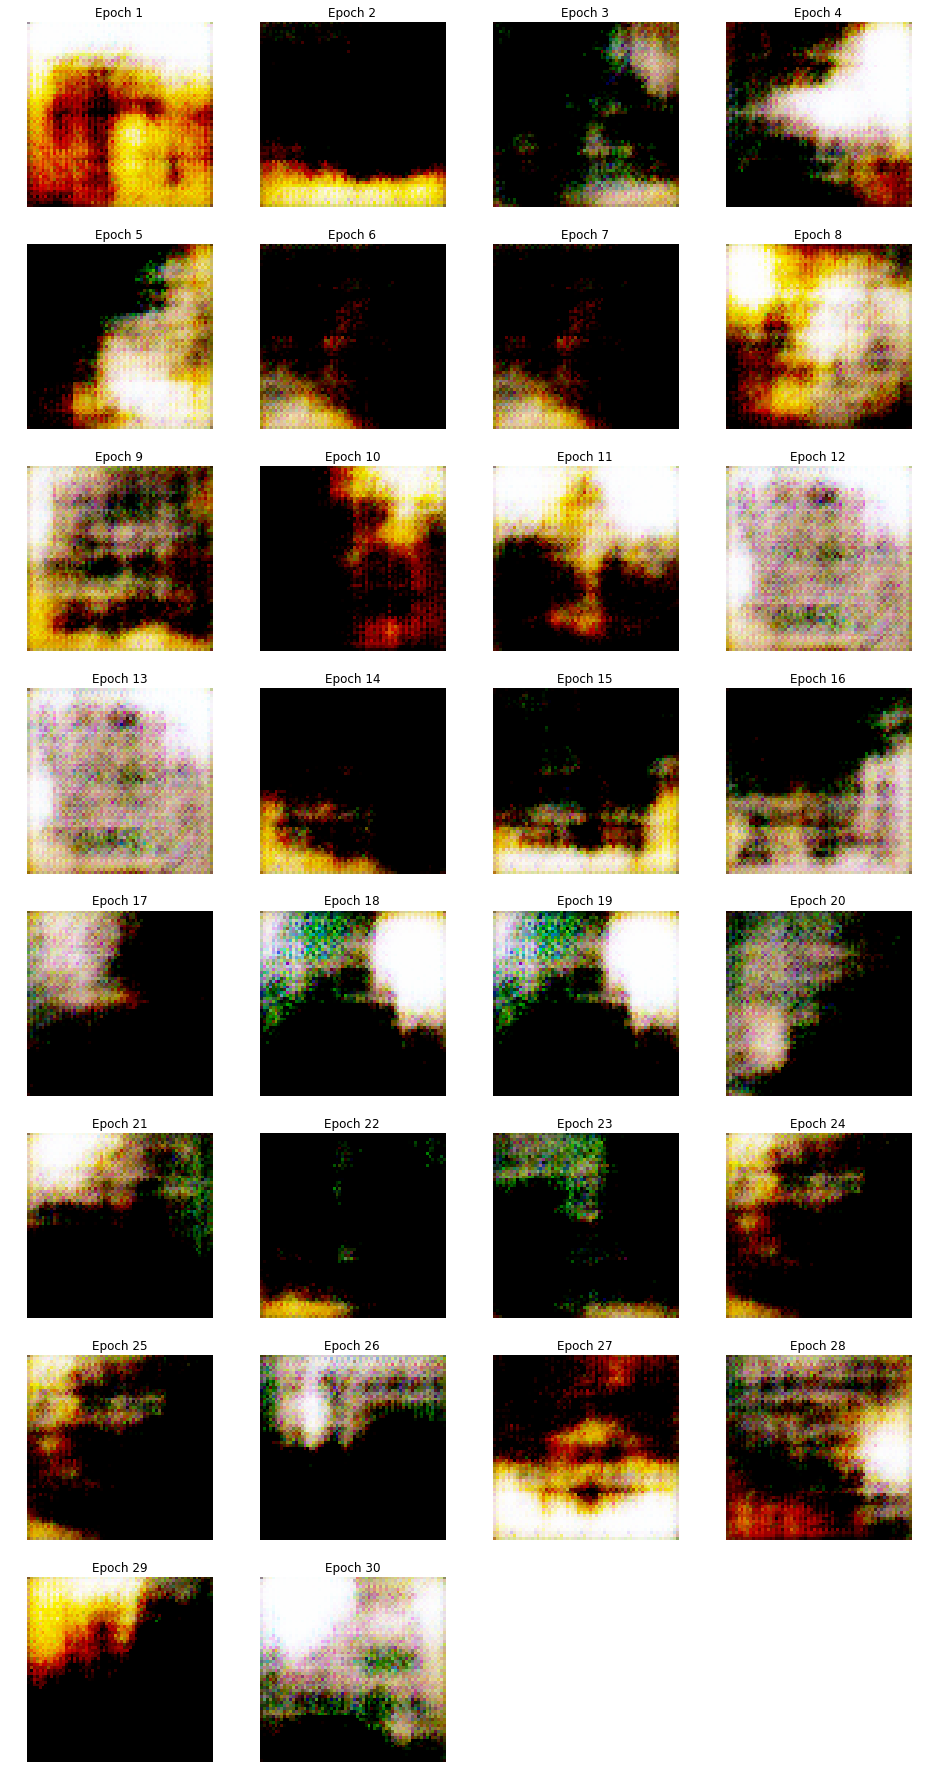

In [14]:
learn.unfreeze()
learn.fit(30,3e-5)

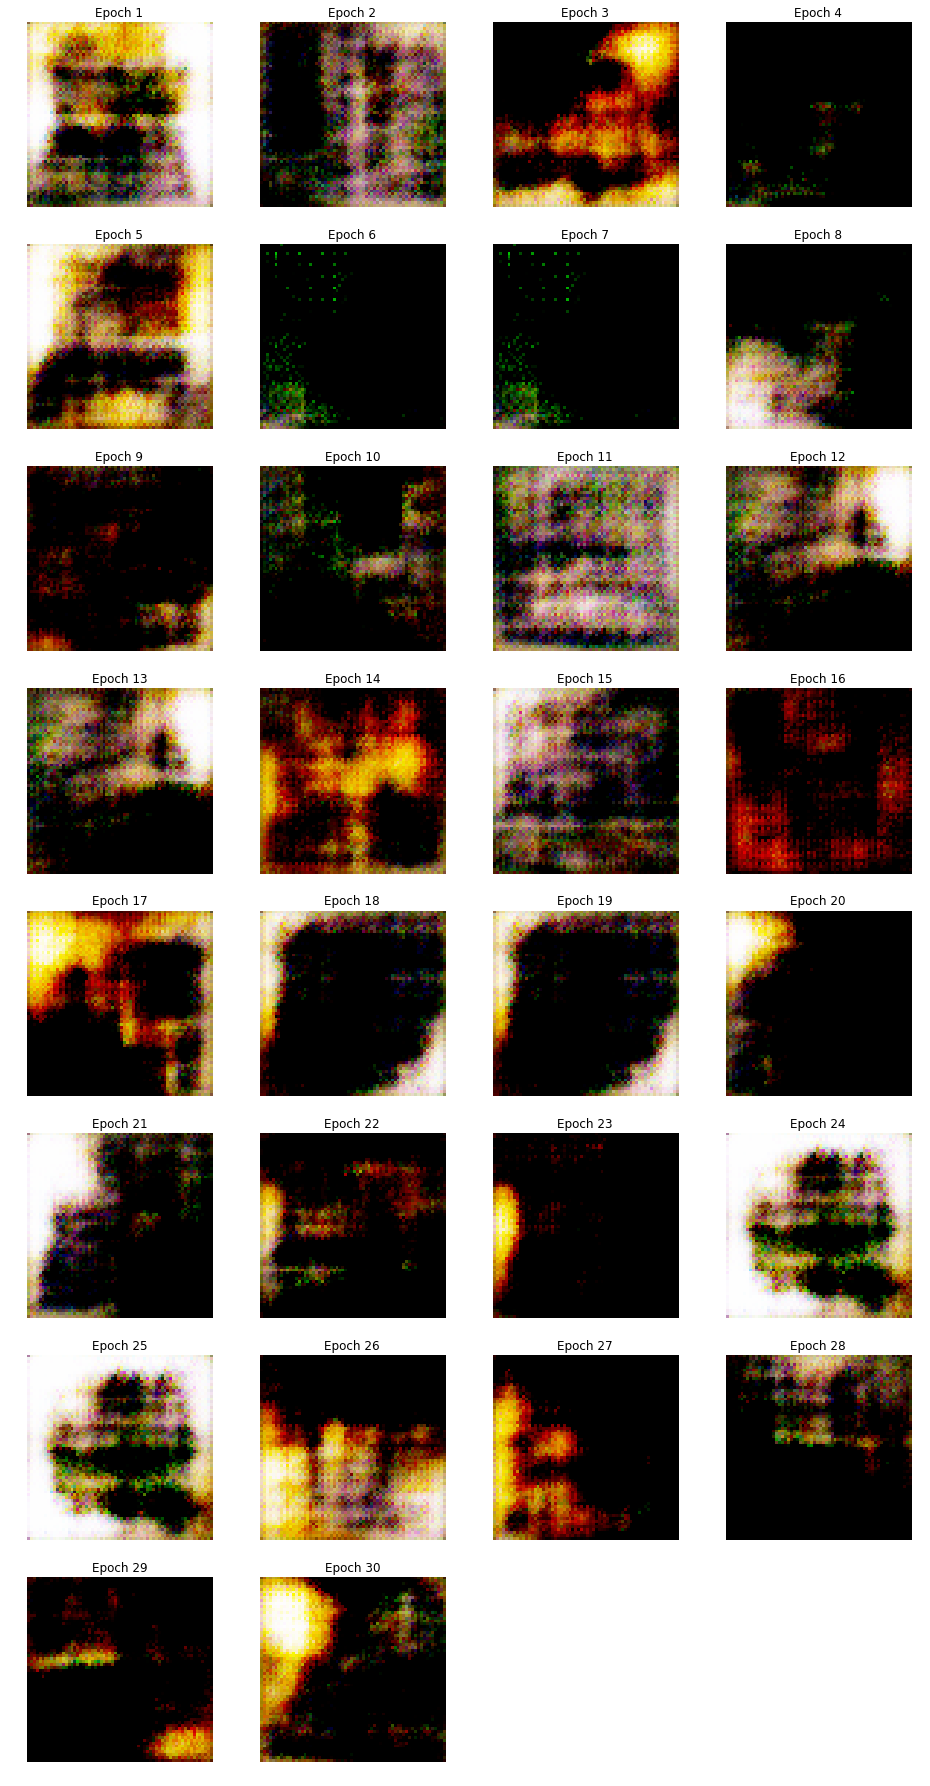

In [17]:
learn.unfreeze()
learn.fit(30,1e-6)

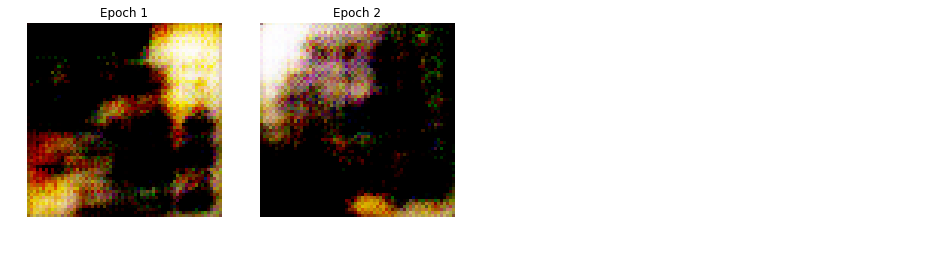

In [20]:
learn.fit(2,1e-5)

In [21]:
learn.save('first-250e')
